In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

df = pd.read_excel("DATASET.xlsx")
df.head()
df['Sample'] = df['Sample'].fillna('').astype(str)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
from sklearn.model_selection import train_test_split

labels = ['Hate Speech', 'Derogatory', 'Trolling', 'Profanity', 'Normal']

X = df['Sample']
y = df['Majority_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def tokenize_data(data):
    return tokenizer(data, padding="max_length", truncation=True, return_tensors='pt')

train_encodings = tokenize_data(X_train.tolist())
test_encodings = tokenize_data(X_test.tolist())


In [3]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from transformers import BertForSequenceClassification, AutoTokenizer

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train.map(lambda x: labels.index(x)) 
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test.map(lambda x: labels.index(x))
})

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

eval_log = trainer.train()
eval_log = trainer.evaluate()

print(f'Evaluation Log: {eval_log}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.743600,0.574516


Evaluation Log: {'eval_loss': 0.5745161175727844, 'eval_runtime': 75.2549, 'eval_samples_per_second': 33.194, 'eval_steps_per_second': 4.159, 'epoch': 1.0}


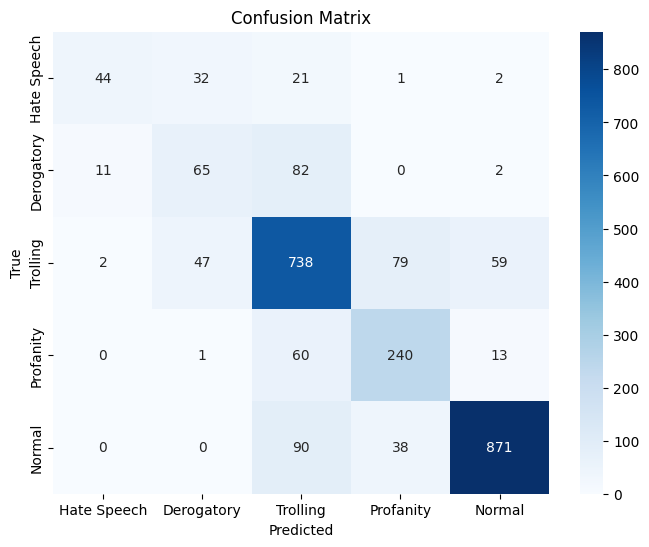

In [ ]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
correct = np.trace(cm)
total = np.sum(cm)
accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.7838270616493195


In [27]:

def predict_class_with_trainer(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)

    from datasets import Dataset
    test_dataset = Dataset.from_dict({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    })

    training_args = TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=16,
        no_cuda=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
    )

    predictions = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    predicted_class = labels[pred_labels[0]]

    return predicted_class

# Example usage: Feed a prompt to the model
prompt = "testing text"
predicted_class = predict_class_with_trainer(prompt)

print(f"Predicted class for the prompt: {predicted_class}")

Predicted class for the prompt: Normal
